In [2]:
import os
import sys
sys.path.append('/home/cocoza4/workspace/absorouteio/asr-face-recognition/src')
import math
import time
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.applications import resnet50, densenet
from PIL import Image
import matplotlib.pyplot as plt

import lfw
import losses
from models import NormDense

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

tf.__version__

'2.1.0'

In [3]:
ckpt_dir = '/home/cocoza4/models/arcface_models/densenet121'

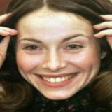

In [4]:
path = '/home/cocoza4/datasets/lfw_mtcnnpy_160/Yekaterina_Guseva/Yekaterina_Guseva_0001.png'
img = Image.open(path).resize((112, 112))
img

In [5]:
np_img = np.asarray(img)

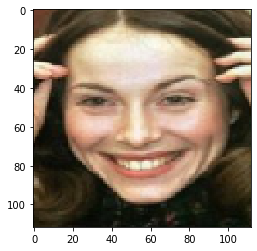

In [6]:
plt.imshow(tf.image.random_flip_left_right(np_img))

In [7]:
img_tensor = tf.constant(np.asarray(img), dtype=tf.float32)
img_tensor.shape

TensorShape([112, 112, 3])

In [8]:
from tensorflow.keras.applications import densenet

In [9]:
img_tensor2 = tf.constant(np.asarray(img), dtype=tf.float32)

In [10]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def imagenet_preprocess(x):
    # image /= 255.
    # image[..., 0] -= mean[0]
    # image[..., 1] -= mean[1]
    # image[..., 2] -= mean[2]
    # image[..., 0] /= std[0]
    # image[..., 1] /= std[1]
    # image[..., 2] /= std[2]
    x /= 255.
    x = tf.stack([x[..., 0] - mean[0], x[..., 1] - mean[1], x[..., 2] - mean[2]], axis=-1)
    x = tf.stack([x[..., 0] / std[0], x[..., 1] / std[1], x[..., 2] / std[2]], axis=-1)
    return x

x1 = imagenet_preprocess(img_tensor)
inputs = x1

In [11]:
x2 = densenet.preprocess_input(img_tensor)

In [12]:
np.isclose(x1, x2, atol=0.001).all()

True

In [13]:
epochs = 2
n_classes = 16
lr = 0.001
m1 = 1.0
m2 = 0.3
m3 = 0.2
s = 64.
img_w = 112
img_h = 112
embedding_size = 512

base_logdir = '/tmp/dir'
data_dir = '/home/cocoza4/datasets/lfw_sample'

In [14]:
initial_learning_rate =lr
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2,
    decay_rate=0.96,
    staircase=True)

In [15]:
optimizer = tf.keras.optimizers.Adam()

In [16]:
lr_schedule(10), tf.cast(128, tf.int64)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0008153726>,
 <tf.Tensor: shape=(), dtype=int64, numpy=128>)

In [22]:
class L2NormDense(tf.keras.layers.Layer):

    def __init__(self, embedding_size):
        super(L2NormDense, self).__init__()
        self.embedding_size = embedding_size

    def build(self, input_shape):
        self.w = self.add_weight(name='norm_dense_w', shape=(input_shape[-1], self.embedding_size),
                                 initializer='random_normal', trainable=True)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        norm_w = tf.nn.l2_normalize(self.w, axis=0)
        x = tf.matmul(inputs, norm_w)
        return x
    

class ArcFaceModel(tf.keras.Model):
    
    def __init__(self, backbone, embedding_size):
        super().__init__()
        self.backbone = backbone
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(0.4)
        self.dense = tf.keras.layers.Dense(embedding_size)
        self.bn2 = tf.keras.layers.BatchNormalization()
#         self.embedding = tf.keras.Sequential([backbone,
#                                     tf.keras.layers.BatchNormalization(), 
#                                    tf.keras.layers.Dropout(0.4),
#                                    tf.keras.layers.Dense(embedding_size),
#                                    tf.keras.layers.BatchNormalization()])
        
    def call(self, inputs, training=False):
        x = self.backbone(inputs, training=training)
        x = self.bn1(x, training=training)
        x = self.dropout(x, training=training)
        x = self.dense(x, training=training)
        x = self.bn2(x, training=training)
#         emb = self.embedding(inputs, training=training)
        return x

In [23]:
# data = data-127.5
# data = data*0.0078125

inputs = (img_tensor - 127.5) * 0.0078125

In [24]:
backbone = tf.keras.applications.DenseNet121(weights=None, include_top=False, pooling='avg')
model = ArcFaceModel(backbone, embedding_size)
model

In [26]:
backbone(tf.expand_dims(inputs, axis=0))

<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
array([[0.03339095, 0.03200115, 0.        , ..., 0.00727066, 0.01401352,
        0.00394028]], dtype=float32)>

In [25]:
embeddings = model(tf.expand_dims(inputs, axis=0), training=True)
embeddings

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

In [20]:
embeddings = tf.stack([tf.ones((1, embedding_size)), tf.ones((1, embedding_size))*2], axis=1)[0]
embeddings

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)>

In [21]:
norm_embedding = tf.nn.l2_normalize(embeddings, axis=1) * s
# embedding = tf.divide(embeddings, norm_embedding, name='norm_embedding')
norm_embedding

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[2.828427, 2.828427, 2.828427, ..., 2.828427, 2.828427, 2.828427],
       [2.828427, 2.828427, 2.828427, ..., 2.828427, 2.828427, 2.828427]],
      dtype=float32)>

In [22]:
random_normal = np.random.normal(size=[norm_embedding.shape[-1], n_classes])
random_normal.shape

(512, 16)

In [25]:
weights = tf.Variable(tf.random.truncated_normal(shape=[norm_embedding.shape[-1], n_classes]), 
                      name='embedding_weights',
                      dtype=tf.float32)
norm_weights = tf.nn.l2_normalize(weights, axis=1)
norm_weights

<tf.Tensor: shape=(512, 16), dtype=float32, numpy=
array([[ 0.23089784, -0.19576837, -0.00297644, ...,  0.43830904,
        -0.25752068,  0.20400454],
       [ 0.14763363,  0.13954352,  0.38521215, ..., -0.32601893,
        -0.3118071 , -0.03877693],
       [-0.1138953 , -0.10328571, -0.3946357 , ...,  0.20803642,
        -0.26186672,  0.1427264 ],
       ...,
       [-0.02901295, -0.48763782, -0.2525702 , ...,  0.11430374,
         0.27522528,  0.00316266],
       [-0.20220576, -0.07652438,  0.00145185, ..., -0.23844944,
        -0.20245512, -0.0876476 ],
       [ 0.06893811,  0.21260113, -0.13160095, ..., -0.09263905,
         0.09682199, -0.3297093 ]], dtype=float32)>

In [26]:
fc7 = tf.matmul(norm_embedding, norm_weights, name='cos_t')
fc7

<tf.Tensor: shape=(2, 16), dtype=float32, numpy=
array([[  7.4979553 ,  -0.06823158,   3.418665  ,   7.9288473 ,
         19.947392  ,  -5.0750046 ,  -0.6554332 , -12.107083  ,
        -15.359625  ,   4.9430833 ,   8.989332  ,  -4.050047  ,
         -9.985912  ,  44.369156  ,   8.424043  ,  28.905846  ],
       [  7.4979553 ,  -0.06823158,   3.418665  ,   7.9288473 ,
         19.947392  ,  -5.0750046 ,  -0.6554332 , -12.107083  ,
        -15.359625  ,   4.9430833 ,   8.989332  ,  -4.050047  ,
         -9.985912  ,  44.369156  ,   8.424043  ,  28.905846  ]],
      dtype=float32)>

In [36]:
labels = tf.constant([1, 0])
labels

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 0], dtype=int32)>

In [42]:
tf.stack([tf.range(norm_embedding.shape[0])[:, None], labels[:, None]], axis=-1)

<tf.Tensor: shape=(2, 1, 2), dtype=int32, numpy=
array([[[0, 1]],

       [[1, 0]]], dtype=int32)>

In [43]:
indices = tf.stack([tf.range(2)[:, None], [[1], [0]]], axis=2)

In [44]:
zy = tf.gather_nd(fc7, indices=indices)
cos_t = zy / s
theta = tf.acos(cos_t)
new_zy = (tf.cos(theta*m1 + m2) - m3)*s
new_zy

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-31.981705],
       [-24.478783]], dtype=float32)>

In [45]:
diff = new_zy - zy
diff

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-31.913473],
       [-31.976738]], dtype=float32)>

In [46]:
fc7 + tf.one_hot(labels, n_classes) * diff

<tf.Tensor: shape=(2, 16), dtype=float32, numpy=
array([[  7.4979553 , -31.981705  ,   3.418665  ,   7.9288473 ,
         19.947392  ,  -5.0750046 ,  -0.6554332 , -12.107083  ,
        -15.359625  ,   4.9430833 ,   8.989332  ,  -4.050047  ,
         -9.985912  ,  44.369156  ,   8.424043  ,  28.905846  ],
       [-24.478783  ,  -0.06823158,   3.418665  ,   7.9288473 ,
         19.947392  ,  -5.0750046 ,  -0.6554332 , -12.107083  ,
        -15.359625  ,   4.9430833 ,   8.989332  ,  -4.050047  ,
         -9.985912  ,  44.369156  ,   8.424043  ,  28.905846  ]],
      dtype=float32)>

In [47]:
cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  # do softmax

In [48]:
loss = cce(labels, fc7)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=40.654293>

In [274]:
def arcface_loss(embeddings, weights, labels, n_classes, m1, m2, m3, s):
    norm_embedding = tf.nn.l2_normalize(embeddings, axis=1) * s
    norm_weights = tf.nn.l2_normalize(weights, axis=1)
    fc7 = tf.matmul(norm_embedding, tf.transpose(norm_weights), name='cos_t')
    print('fc7=', fc7)
    indices = tf.stack([tf.range(norm_embedding.shape[0])[:, None], labels[:, None]], axis=-1)
    zy = tf.gather_nd(fc7, indices=indices)
    print('zy=', zy)
    cos_t = zy / s
    theta = tf.acos(cos_t)
    new_zy = (tf.cos(theta*m1 + m2) - m3) * s
    diff = new_zy - zy
    prelogits = fc7 + tf.one_hot(labels, n_classes) * diff
    print('prelogits=', prelogits)
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    loss = cce(labels, prelogits)

    return loss

In [227]:
np_embeddings = np.random.normal(size=(5, embedding_size))
np_weights = np.random.normal(size=(n_classes, embedding_size))

labels = tf.constant([0, 1, 4, 2, 3])
embeddings = tf.constant(np_embeddings, dtype=tf.float32)
weights = tf.Variable(np_weights, name='embedding_weights', dtype=tf.float32)

embeddings.shape, weights.shape

(TensorShape([5, 512]), TensorShape([16, 512]))

In [275]:
arcface_loss(embeddings, weights, labels, n_classes, m1, m2, m3, s)

fc7= tf.Tensor(
[[-2.910559   -3.9620328   1.6998463   0.0272425   2.4370673   3.0524569
   2.473774    0.8501934  -0.40028608 -0.52222866  0.66060793 -1.7203678
  -1.0160695  -4.8744855   4.8073797  -0.26680616]
 [-1.2385546  -5.5817657   0.97211874  5.531597   -2.4118524   2.2462857
  -0.26295292 -4.146698    0.55164087 -1.9658827   3.5574236   0.2915513
  -1.5796915  -1.8974855   0.79433656 -3.5392156 ]
 [ 2.893534    4.273507   -2.0104144  -3.0288854  -3.5924366  -7.273546
   5.5545826  -0.68141985  5.766289    1.1975936   1.3605207  -4.2466326
   0.05442506 -6.0209684  -2.6446793  -1.9890023 ]
 [-2.0380847  -2.90378     1.2825438  -3.0458374  -1.3411428  -4.004463
  -1.7627962  -3.605618   -2.5015554   2.016554    2.4471061  -2.9141188
  -1.0378156  -0.25354087 -2.1918528   3.6685443 ]
 [-2.0975096   1.2166425  -3.5478241   4.082995   -0.52101827  3.376806
   3.0527265   0.3423121   1.7714934   1.6130211   0.03371251 -2.2590165
  -4.254635    1.5881655   2.7840953  -4.4861636 ]], 

<tf.Tensor: shape=(), dtype=float32, numpy=38.41543>

In [280]:
weights

<tf.Variable 'embedding_weights:0' shape=(16, 512) dtype=float32, numpy=
array([[-1.3714445 ,  0.6102413 ,  1.2176465 , ..., -0.33853343,
        -0.07868385, -1.7489275 ],
       [-1.4020383 ,  0.19703534,  0.26772743, ...,  0.23684995,
        -0.478334  , -0.7045912 ],
       [ 0.07071999, -1.0851623 , -1.3503605 , ..., -1.158318  ,
        -1.713893  ,  0.54873013],
       ...,
       [-0.56310034,  0.74796706,  0.47218287, ..., -0.26835915,
         0.4659443 ,  1.3118677 ],
       [-0.1304542 , -0.19208422, -0.63448477, ...,  2.2295833 ,
        -0.11614412,  2.1463945 ],
       [ 0.64240384,  1.6414108 ,  0.35120776, ..., -0.02283437,
        -1.7733697 ,  1.3175623 ]], dtype=float32)>

In [300]:
@tf.function
def train_step(emb_weights, labels, optimizer):
    with tf.GradientTape(persistent=False) as tape:
        loss = losses.arcface_loss(embeddings, emb_weights, labels, n_classes, m1, m2, m3, s)
    
    trainable_vars = model.trainable_variables + [emb_weights]
    gradients = tape.gradient(loss, trainable_vars)
    print(gradients)
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    return loss

In [302]:
weights

<tf.Variable 'embedding_weights:0' shape=(16, 512) dtype=float32, numpy=
array([[-1.3634387 ,  0.6022406 ,  1.2096459 , ..., -0.34653515,
        -0.08668374, -1.740978  ],
       [-1.3940362 ,  0.18903764,  0.25972864, ...,  0.22883812,
        -0.47035524, -0.6966037 ],
       [ 0.0787165 , -1.0931604 , -1.3423576 , ..., -1.1663154 ,
        -1.7058632 ,  0.5567278 ],
       ...,
       [-0.55516416,  0.75594515,  0.46419418, ..., -0.27628243,
         0.45799148,  1.3038871 ],
       [-0.12240543, -0.18408631, -0.6265183 , ...,  2.2373037 ,
        -0.11416768,  2.1383696 ],
       [ 0.6344091 ,  1.649404  ,  0.34321377, ..., -0.01484031,
        -1.7813344 ,  1.3095666 ]], dtype=float32)>

# mxnet debug

In [261]:
import mxnet as mx
from mxnet import nd

In [262]:
def mx_execute(symbol, tensors):
    shapes = {n: t.shape for n, t in tensors.items()}
    executor = symbol.simple_bind(ctx=mx.cpu(), **shapes)
    return executor.forward(**tensors)

In [263]:
mx_embeddings = nd.from_numpy(np_embeddings)
mx_embeddings.asnumpy().shape

(5, 512)

In [264]:
sym_embeddings = mx.sym.Variable('embedding')
sym_norm_embedding = mx.symbol.L2Normalization(sym_embeddings, mode='instance', name='fc1n')*s
sym_norm_embedding

<Symbol _mulscalar32>

In [265]:
mx_execute(sym_embeddings, tensors={'embedding': mx_embeddings.asnumpy()})

[
 [[ 0.16567217 -0.5138774  -1.465143   ... -0.47938612 -0.5396267
    0.18893166]
  [ 1.3971676  -0.57976687 -1.2257227  ... -0.6483906   0.37910756
    1.5813632 ]
  [ 0.19040789  0.27145928 -0.51437813 ...  1.0478523   0.14038257
    2.1139185 ]
  [ 0.51160043 -1.771226    1.87588    ... -1.295358    0.02411172
    1.1257058 ]
  [-1.5075265  -1.4637234   0.87083215 ...  2.0135872   2.074586
    0.8487281 ]]
 <NDArray 5x512 @cpu(0)>]

In [266]:
sym_weights = mx.sym.Variable(name='weights')
sym_norm_weights = mx.symbol.L2Normalization(sym_weights, mode='instance')
sym_norm_weights

<Symbol l2normalization11>

In [267]:
tensors = {'weights': np_weights}
mx_execute(sym_norm_weights, tensors)

[
 [[-0.05850128  0.02603088  0.05194077 ... -0.01444072 -0.00335639
   -0.07460346]
  [-0.06248928  0.00878193  0.01193269 ...  0.01055647 -0.02131949
   -0.03140385]
  [ 0.00316924 -0.0486303  -0.06051485 ... -0.05190869 -0.07680614
    0.02459071]
  ...
  [-0.02600219  0.03453875  0.02180391 ... -0.01239198  0.02151583
    0.0605779 ]
  [-0.00580176 -0.00854267 -0.0282178  ...  0.09915753 -0.00516534
    0.09545783]
  [ 0.02727805  0.06969836  0.01491315 ... -0.0009696  -0.07530165
    0.05594695]]
 <NDArray 16x512 @cpu(0)>]

In [268]:
fc7 = mx.sym.FullyConnected(data=sym_norm_embedding, weight=sym_norm_weights, no_bias=True, 
                            num_hidden=n_classes, name='fc7')
fc7

<Symbol fc7>

In [269]:
tensors = {'embedding': mx_embeddings.asnumpy(), 'weights': np_weights}
mx_execute(fc7, tensors)

[
 [[-2.9105597  -3.9620328   1.6998475   0.02724296  2.437067    3.0524585
    2.4737759   0.850194   -0.40028584 -0.52222973  0.6606089  -1.7203678
   -1.0160701  -4.8744855   4.8073807  -0.2668058 ]
  [-1.2385551  -5.581765    0.97211957  5.5315967  -2.4118528   2.2462847
   -0.26295263 -4.1466994   0.5516411  -1.9658831   3.557424    0.291551
   -1.5796909  -1.8974856   0.7943368  -3.539216  ]
  [ 2.893534    4.273507   -2.0104156  -3.0288887  -3.592438   -7.2735476
    5.5545845  -0.68142056  5.7662907   1.1975948   1.3605216  -4.2466326
    0.05442429 -6.020972   -2.644681   -1.9890022 ]
  [-2.0380836  -2.9037793   1.282544   -3.045838   -1.3411424  -4.0044627
   -1.7627964  -3.605617   -2.5015552   2.0165544   2.4471066  -2.9141183
   -1.0378158  -0.25354064 -2.1918526   3.6685438 ]
  [-2.0975096   1.2166425  -3.547824    4.0829964  -0.52101755  3.376807
    3.0527275   0.34231272  1.771493    1.6130198   0.03371274 -2.2590165
   -4.254636    1.588166    2.7840962  -4.486164  ]]

In [270]:
gt_label = mx.symbol.Variable('softmax_label')
zy = mx.sym.pick(fc7, gt_label, axis=1)
tensors = {'embedding': mx_embeddings.asnumpy(), 'weights': np_weights, 'softmax_label': labels.numpy()}
mx_execute(zy, tensors)

[
 [-2.9105597 -5.581765  -3.592438   1.282544   4.0829964]
 <NDArray 5 @cpu(0)>]

In [271]:
gt_label = mx.symbol.Variable('softmax_label')
zy = mx.sym.pick(fc7, gt_label, axis=1)
cos_t = zy/s
t = mx.sym.arccos(cos_t)
t = t*m1 + m2
body = mx.sym.cos(t) - m3
new_zy = body*s
diff = new_zy - zy
diff = mx.sym.expand_dims(diff, 1)
gt_one_hot = mx.sym.one_hot(gt_label, depth = n_classes, on_value=1.0, off_value=0.0)
body = mx.sym.broadcast_mul(gt_one_hot, diff)
fc7 = fc7+body
fc7

<Symbol _plus10>

In [272]:
tensors = {'embedding': mx_embeddings.asnumpy(), 'weights': np_weights, 'softmax_label': labels.numpy()}
mx_execute(zy, tensors)

[
 [-2.9105597 -5.581765  -3.592438   1.282544   4.0829964]
 <NDArray 5 @cpu(0)>]

In [273]:
tensors = {'embedding': mx_embeddings.asnumpy(), 'weights': np_weights, 'softmax_label': labels.numpy()}
mx_execute(fc7, tensors)

[
 [[-3.4754227e+01 -3.9620328e+00  1.6998475e+00  2.7242959e-02
    2.4370670e+00  3.0524585e+00  2.4737759e+00  8.5019398e-01
   -4.0028584e-01 -5.2222973e-01  6.6060889e-01 -1.7203678e+00
   -1.0160701e+00 -4.8744855e+00  4.8073807e+00 -2.6680580e-01]
  [-1.2385551e+00 -3.7336891e+01  9.7211957e-01  5.5315967e+00
   -2.4118528e+00  2.2462847e+00 -2.6295263e-01 -4.1466994e+00
    5.5164111e-01 -1.9658831e+00  3.5574241e+00  2.9155099e-01
   -1.5796909e+00 -1.8974856e+00  7.9433680e-01 -3.5392160e+00]
  [ 2.8935339e+00  4.2735071e+00 -2.0104156e+00 -3.0288887e+00
   -3.5415619e+01 -7.2735476e+00  5.5545845e+00 -6.8142056e-01
    5.7662907e+00  1.1975948e+00  1.3605216e+00 -4.2466326e+00
    5.4424286e-02 -6.0209718e+00 -2.6446810e+00 -1.9890022e+00]
  [-2.0380836e+00 -2.9037793e+00 -3.0655312e+01 -3.0458381e+00
   -1.3411424e+00 -4.0044627e+00 -1.7627964e+00 -3.6056170e+00
   -2.5015552e+00  2.0165544e+00  2.4471066e+00 -2.9141183e+00
   -1.0378158e+00 -2.5354064e-01 -2.1918526e+00  3

In [183]:
softmax = mx.symbol.SoftmaxOutput(data=fc7, label = gt_label, name='softmax', normalization='valid')

In [184]:
tensors = {'embedding': mx_embeddings.asnumpy(), 'weights': np_weights}
mx_execute(softmax, tensors)

[
 [[5.7522517e-19 1.2339576e-04 3.3459044e-05 3.4132139e-05 1.0274089e-03
   3.6225510e-06 1.2177359e-04 1.6971401e-04 9.9591297e-01 5.1345275e-04
   6.6986017e-06 6.9383779e-05 2.5761433e-04 1.7112087e-03 1.4484028e-05
   6.9543887e-07]
  [1.5419292e-16 7.3107421e-02 3.3567178e-03 8.1192113e-02 5.1313568e-06
   7.7816858e-03 8.9615869e-04 2.2875017e-02 1.3042900e-02 5.8446085e-01
   6.4095862e-02 2.9596910e-03 4.5561632e-05 4.0147729e-02 5.9691714e-03
   1.0006399e-01]
  [1.0237157e-18 2.3379815e-03 8.9311326e-04 1.9868864e-01 5.6828372e-03
   3.4997392e-02 1.0700584e-02 3.8567188e-04 1.2197540e-01 3.0328749e-02
   2.9320105e-03 1.4653693e-01 6.8894034e-04 4.3724740e-01 6.0990215e-03
   5.0535909e-04]
  [5.2412932e-16 7.1699275e-03 2.6652103e-02 1.0323022e-03 1.1299771e-02
   1.1403231e-04 2.3460147e-05 3.3519045e-02 3.4728523e-02 3.7039801e-01
   3.3370410e-03 1.1048654e-02 2.5290224e-01 4.4884611e-02 3.1756196e-02
   1.7113417e-01]
  [5.3158408e-17 5.9222456e-02 4.0884342e-02 3.903

In [ ]:
body = mx.sym.BatchNorm(data=body, fix_gamma=False, eps=2e-5, momentum=bn_mom, name='bn1')
body = mx.symbol.Dropout(data=body, p=0.4)
fc1 = mx.sym.FullyConnected(data=body, num_hidden=num_classes, name='pre_fc1')
fc1 = mx.sym.BatchNorm(data=fc1, fix_gamma=True, eps=2e-5, momentum=bn_mom, name='fc1')

In [9]:
backbone = tf.keras.Sequential([
    tf.keras.applications.DenseNet121(include_top=False, pooling=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(n_classes),
    tf.keras.layers.BatchNormalization()
])

backbone

In [10]:
model = ArcFaceModel(backbone, n_classes)

In [12]:
@tf.function
def train_step(model, inputs, labels):
    with tf.GradientTape() as tape:
        prelogits, norm_dense = model(inputs, training=True)
        loss = losses.arcface_loss(prelogits, norm_dense, labels, m1, m2, m3, s)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

@tf.function
def test_step(model, images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    prelogits, norm_dense = model(images, training=True) # training mode as loss is calculated
    loss = losses.arcface_loss(prelogits, norm_dense, labels, m1, m2, m3, s)

    return loss

@tf.function
def predict_embedding(model, images):
    embeddings = model(images, training=False)
    return embeddings


def preprocess(path, training=True):
    raw = tf.io.read_file(path)
    image = tf.image.decode_png(raw)
    if training:
        image = tf.image.random_flip_left_right(image)
#     image = tf.cast(image, tf.float32)
    image = densenet.preprocess_input(image)
    image = tf.image.resize(image, (img_w, img_h))
    
    # image = tf.image.resize(image, (224, 224))
    # image = tf.image.random_crop(image, size=[112, 112, 3])

    # image = image[None, ...]
    return image


def get_data(path):
    ids = [o for o in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, o))]
    ids.sort()
    cat_num = len(ids)

    id_dict = dict(zip(ids, list(range(cat_num))))
    paths = []
    labels = []
    for i in ids:
        cur_dir = os.path.join(path, i)
        fns = os.listdir(cur_dir)
        paths.append([os.path.join(cur_dir, fn) for fn in fns])
        labels.append([id_dict[i]] * len(fns))

    return paths, labels

def generate(path, preprocess_fn=preprocess, batch_size=128):
    paths, labels = get_data(path)
    n_classes = len(paths)
    paths = [path for cls in paths for path in cls]
    labels = [label for cls in labels for label in cls]
    
    assert (len(paths) == len(labels))
    def p(inputs, labels): return preprocess_fn(inputs), labels
    
    ds = (tf.data.Dataset.from_tensor_slices((paths, labels))
          .cache()
          .shuffle(20000)
          .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
          .map(p, num_parallel_calls=tf.data.experimental.AUTOTUNE)
          .batch(batch_size))
    
    return ds

def evaluate(model, lfw_paths, actual_issame, batch_size, n_folds):
    n_images = len(actual_issame) * 2
    assert len(lfw_paths) == n_images

    embs_array = np.zeros((n_images, args.embedding_size))
    it = tqdm(range(0, n_images, batch_size), 'Predict embeddings')
    for start in it:
        end = start + batch_size
        preprocessed = np.array([preprocess(path, training=False) for path in lfw_paths[start:end]])
        embs_array[start:end] = predict_embedding(model, preprocessed)
        
    _, _, accuracy, val, val_std, far = lfw.evaluate(embs_array, actual_issame, n_folds=n_folds)
    
    print('Accuracy: %1.3f+-%1.3f' % (np.mean(accuracy), np.std(accuracy)))
    print('Validation rate: %2.5f+-%2.5f @ FAR=%2.5f' % (val, val_std, far))

    return np.mean(accuracy), val

In [13]:
join_path = lambda p, x: os.path.isdir(os.path.join(p, x))
[o for o in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, o))]

['Jackie_Chan',
 'Anna_Faris',
 'Ricardo_Sanchez',
 'Mahdi_Al_Bassam',
 'Madonna',
 'Alan_Greenspan',
 'Lisa_Girman',
 'Li_Peng',
 'Daniel_Darnell',
 'Emma_Thompson',
 'Igor_Ivanov',
 'Emma_Watson',
 'Annie_Chaplin',
 'Wu_Peng',
 'Clint_Eastwood',
 'Coco_dEste']

In [33]:
global_step = tf.Variable(5)
ckpt = tf.train.Checkpoint(global_step=global_step, backbone=model.backbone, model=model, optimizer=optimizer)

In [34]:
ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=10, 
                                          checkpoint_name='densenet121')

In [36]:
global_step.assign_add(1)


<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=6>

In [37]:
ckpt.global_step.assign(global_step)

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=6>

In [16]:
ckpt.restore(ckpt_manager.latest_checkpoint)

In [29]:
import csv

file = '/home/cocoza4/workspace/absorouteio/asr-face-recognition/src/lfw.txt'

exists = os.path.exists(file)
columns = ['accuracy', 'val', 'far', 'frr']

with open(file, mode='a+') as f:
    writer = csv.DictWriter(f, fieldnames=columns)
    if not exists:
        writer.writeheader()
    writer.writerow({'accuracy': 0.999, 'val': 0.63, 'far': 0.22, 'frr': 0.232})
    writer.writerow({'accuracy': 0.998, 'val': 0.63, 'far': 0.22, 'frr': 0.232})

In [ ]:
# epoch = 20, last step = 243301


In [44]:
current_time = datetime.now().strftime("%Y-%m-%d")
logdir = os.path.join(base_logdir, current_time)

summary = tf.compat.v2.summary
writer = summary.create_file_writer(logdir)

global_step = tf.Variable(0, name="global_step", dtype=tf.int64)

# pairs = lfw.read_pairs(args.lfw_pairs)
# lfw_paths, actual_issame = lfw.get_paths(args.lfw_dir, pairs)

train_gen = generate(data_dir, batch_size=4)

In [45]:
# preprocessed = [preprocess(path) for path in lfw_paths[0:2]]
# np.array(preprocessed).shape

In [46]:
# np.array(preprocessed).shape

In [36]:
ckpt_dir = './models'

In [37]:
ckpt = tf.train.Checkpoint(backbone=model.backbone, model=model, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=10, checkpoint_name='model')

In [39]:
save_path = ckpt_manager.save()
print('Saving checkpoint for epoch {} at {}'.format(epoch, save_path))

Saving checkpoint for epoch 1 at ./models/model-1


In [16]:
# summary_dir = '/tmp/logs'
# current_time = datetime.now().strftime("%Y-%m-%d")
# train_logdir = summary_dir # os.path.join(summary_dir, current_time, 'train')
# # valid_log_dir = os.path.join(summary_dir, current_time, 'valid')

# # summary_writer = tf.compat.v2.summary.create_file_writer(current_time)
# writer = tf.compat.v2.summary.create_file_writer(train_logdir)
# summary = tf.compat.v2.summary

In [17]:
steps_per_epoch = 5
epoch = 0
lfw_n_folds = 10
eval_every = 1
batch_size = 32

global_step = tf.Variable(0, name="global_step", dtype=tf.int64)

lfw_dir = '/home/cocoza4/datasets/lfw_mtcnnpy_160'
lfw_pairs = lfw_dir + '/pairs.txt'

In [18]:
train_gen = generate(data_dir, batch_size=8)

In [19]:
pairs = lfw.read_pairs(lfw_pairs)
lfw_paths, actual_issame = lfw.get_paths(lfw_dir, pairs)

In [56]:
with writer.as_default():
    for epoch in range(epochs):

        for inputs, targets in train_gen:
            t1 = time.time()
            loss = train_step(model, inputs, targets)
            elapsed = time.time() - t1
            summary.scalar('train/loss', loss, step=global_step)
            current_lr = lr_schedule(global_step)
            print('Epoch: %d\tStep: %d\tTime %.3f\tLoss %2.3f\tLearning Rate: %.5f' % 
                    (epoch+1, global_step, elapsed, loss, current_lr))

            global_step.assign_add(1)

#         if epoch % eval_every == 0 or epoch == epochs-1:
#             t1 = time.time()
#             accuracy, val = evaluate(lfw_paths, actual_issame, batch_size, lfw_n_folds)
#             time_elapsed = time.time() - t1
# #             summary.scalar('lfw/time_elapsed', loss, step=global_step)
#             summary.scalar('lfw/accuracy', simple_value=accuracy)
#             summary.scalar('lfw/val_rate', simple_value=val)
#             summary.scalar('lfw/time_elapsed', simple_value=time_elapsed)

    #     summary_writer.add_summary(summary, step)
        writer.flush()


Epoch: 1	Step: 0	Time 14.270	Loss 37.514	Learning Rate: 0.00010
Epoch: 1	Step: 1	Time 1.121	Loss 37.410	Learning Rate: 0.00010
Epoch: 1	Step: 2	Time 0.800	Loss 38.433	Learning Rate: 0.00010
Epoch: 1	Step: 3	Time 1.143	Loss 39.163	Learning Rate: 0.00010
Epoch: 1	Step: 4	Time 1.196	Loss 35.346	Learning Rate: 0.00009
Epoch: 1	Step: 5	Time 1.652	Loss 35.684	Learning Rate: 0.00009
Epoch: 1	Step: 6	Time 0.970	Loss 36.890	Learning Rate: 0.00009
Epoch: 1	Step: 7	Time 0.521	Loss 35.145	Learning Rate: 0.00009
Epoch: 1	Step: 8	Time 0.487	Loss 35.901	Learning Rate: 0.00008
Epoch: 1	Step: 9	Time 0.746	Loss 35.347	Learning Rate: 0.00008
Epoch: 1	Step: 10	Time 0.557	Loss 34.618	Learning Rate: 0.00008
Epoch: 1	Step: 11	Time 0.597	Loss 38.595	Learning Rate: 0.00008
Epoch: 1	Step: 12	Time 0.781	Loss 34.713	Learning Rate: 0.00008
Epoch: 1	Step: 13	Time 0.736	Loss 34.317	Learning Rate: 0.00008
Epoch: 1	Step: 14	Time 0.546	Loss 35.636	Learning Rate: 0.00008
Epoch: 1	Step: 15	Time 0.489	Loss 34.384	Learning